In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from eofs.xarray import Eof


In [59]:
ERA5="/dat1/gmanuch/ERA5/winds_sst_pres_prec.nc"
era = xr.open_dataset(ERA5)
era

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 756)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2021-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-21 07:34:29 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

C

In [ ]:
era['tp'].sel(time=slice("2013-05", "2013-07"));  # choosing a variable and slicing a time range

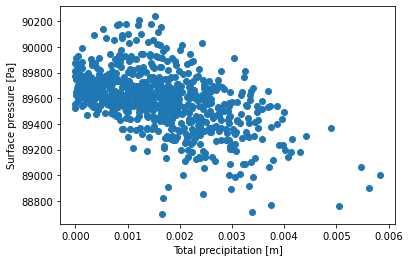

In [61]:
era.sel(longitude=240.2, latitude=45, method="nearest").plot.scatter('tp','sp'); # finding a point nearest to desired lat/lon, and plotting a scatter plot using the resulting timeseries of surface pressure and total precipitation variables.


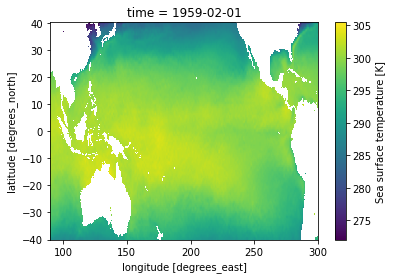

In [62]:
era.sel(longitude=slice(90, 300)).sel(latitude=slice(40,-40)).isel(time=1)['sst'].plot(); # focus on the pacific ocean

In [63]:
#sst=era['sst'].sel(time=slice("2010-01", "2020-01"))
sst=era['sst'];

In [64]:
sst_clim=sst.groupby("time.month").mean('time'); # creating monthly mean climatology for sst
sst_a = sst.groupby("time.month")-sst_clim;      # xarray can figure out the broadcasting to take the difference between sst(t) and sst(month)

/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [65]:
NINO3_INCORRECT = sst_a.sel(latitude=slice(5,-5), longitude=slice(-170+360,-120+360)).mean(dim=['latitude','longitude']) # this is taking mean of pixel values, not area averages. 
SSTa_global_mean_INCORRECT = sst_a.mean(dim=['latitude','longitude']);# this is NOT area-averaged, just pixel averaged
SST_global_mean_INCORRECT = sst.mean(dim=['latitude','longitude']); # this is NOT area-weighted mean

#For the global mean temperature the pixel average is significantly different from area averages!

weights = np.cos(np.deg2rad(era.latitude)); weights.name = "weights"; # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.

NINO3 = sst_a.sel(latitude=slice(5,-5), longitude=slice(-170+360,-120+360)).weighted(weights).mean(dim=['latitude','longitude']) # this is taking mean of pixel values, not area averages. 

SSTa_global_mean= sst_a.weighted(weights).mean(dim=['latitude','longitude']); # this IS area-weighted mean

SST_global_mean = sst.weighted(weights).mean(dim=['latitude','longitude']); # this IS area-weighted mean

/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


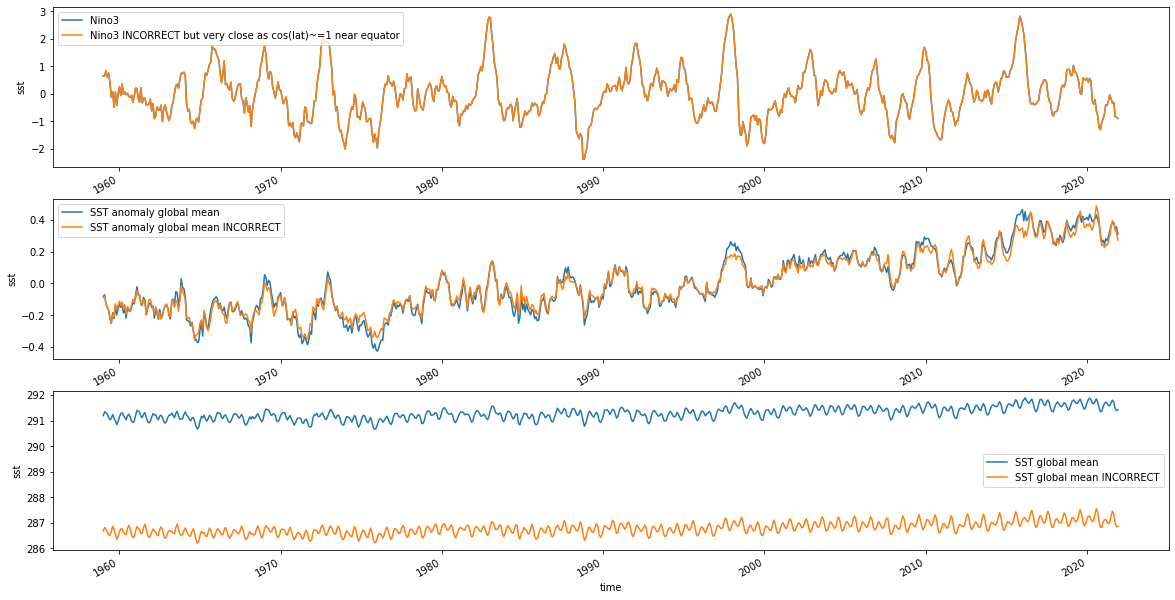

In [66]:
plt.figure(figsize=(20,10))

ax=plt.subplot(3,1,1)
NINO3.plot(ax=ax,label="Nino3" )
NINO3_INCORRECT.plot(ax=ax,label="Nino3 INCORRECT but very close as cos(lat)~=1 near equator" )

plt.legend()

ax=plt.subplot(3,1,2)
SSTa_global_mean.plot(ax=ax,label="SST anomaly global mean" );
SSTa_global_mean_INCORRECT.plot(ax=ax,label="SST anomaly global mean INCORRECT" );
plt.legend()

ax=plt.subplot(3,1,3)
SST_global_mean.plot(ax=ax,label="SST global mean" );
SST_global_mean_INCORRECT.plot(ax=ax,label="SST global mean INCORRECT" );

plt.legend()

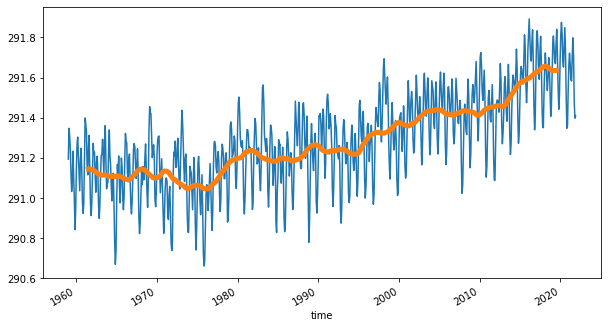

In [67]:
#The mean SST and it's anomaly from climatology have long-term positive trends (global warming!)
# Let's calculate a running mean to more clearly see this trend

SST_global_mean_runningMean=SST_global_mean.rolling(time=12*5,center=True).mean() # global mean
SSTa_global_mean_runningMean=SSTa_global_mean.rolling(time=12*5,center=True).mean(); # global mean anomaly from seasonal cycle


#NOAA defines NINO3 as a 3-month running mean SST anomaly, so let's fix this here:
NINO3= NINO3.rolling(time=3,center=True).mean();


SST_global_mean.plot(figsize=(10,5),label="SST" );
SST_global_mean_runningMean.plot(label="SST rolling mean", linewidth=5 );


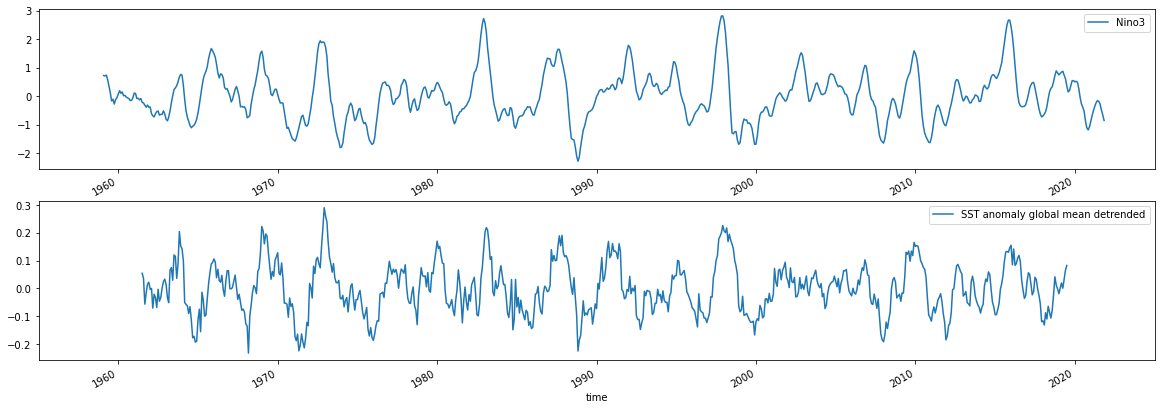

In [68]:
# to have a cleaner view of global temperature relation to ENSO, let's remove the long-term trends.
SSTa_global_mean_Detrended=(SSTa_global_mean-SSTa_global_mean_runningMean);

plt.figure(figsize=(20,10))

ax=plt.subplot(3,1,1)
NINO3.plot(ax=ax,label="Nino3", xlim=('1955','2025'))
plt.legend()

ax=plt.subplot(3,1,2)
SSTa_global_mean_Detrended.plot(ax=ax,label="SST anomaly global mean detrended" , xlim=('1955','2025'));
plt.legend()

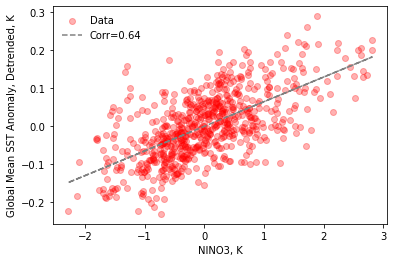

In [69]:
#Now we can clearly see the strong correlation between the Global Ocean Temperature and ENSO defined using NINO3 index
plt.figure; 
plt.scatter(NINO3,SSTa_global_mean_Detrended,color='red',alpha=0.3);
plt.xlabel('NINO3, K');
plt.ylabel('Global Mean SST Anomaly, Detrended, K');

# let's add a simple regression line
x=NINO3.data; y=SSTa_global_mean_Detrended.data;
x=x[~np.isnan(y)];  y=y[~np.isnan(y)]; # remove nan that polyfit can't deal with

m, b = np.polyfit(x,y, 1) # fit a first order polynomial, i.e. a straight line

correlation = np.corrcoef(x, y)[0,1] #calculate correlation coefficient
c_str='Corr='+str(np.fix(correlation*100)/100); # create a string to display the correction as a legend

plt.plot(x, m*x+b, linestyle='--',color='gray') # plot that straight line
plt.legend(('Data',c_str),frameon=False)

In [1]:
#from NINO3 timeseries we can pick a strong El Nino event and plot the ocean SSTa
sst_a.sel(time='2016-02').plot(figsize=(30,15),cmap='RdBu_r', vmin=-3, vmax=3);

NameError: name 'sst_a' is not defined

In [71]:
sst_a_coarse=sst_a.coarsen(longitude=5, latitude=5, boundary="trim").mean(); # coarsen the data to a 1x1 degree from a 0.25x0.25 degree; could do it to begin with to save computing!

/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


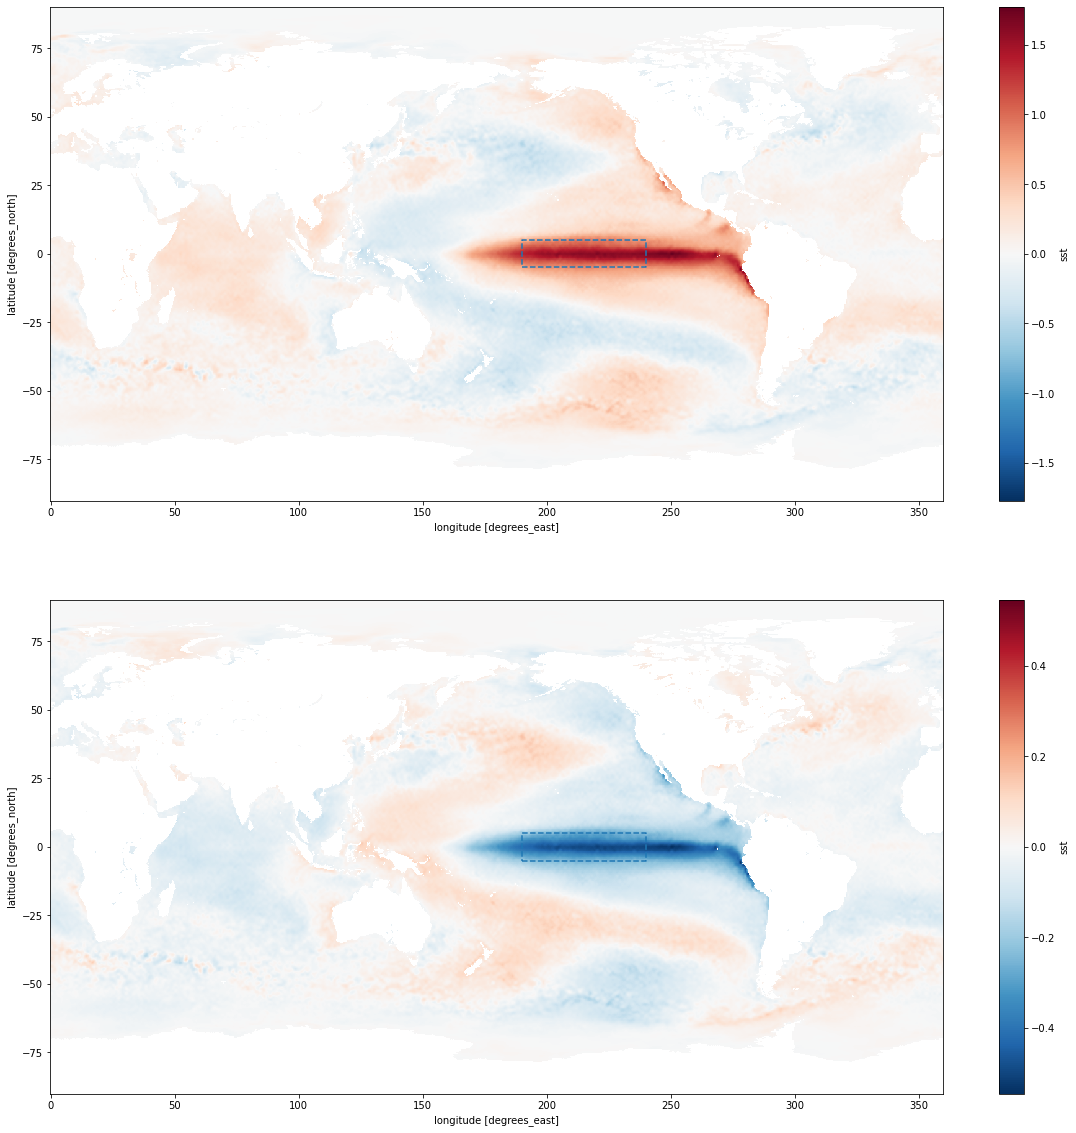

In [111]:
#learn how to compute conditional averages; 
#for example El Nino evens are defined as NINO3>0.5, while La Nina as NINO3<-0.5. 
#See what the world's temperature anomaly looks like conditioned onto El Nino or La Nina

plt.figure(figsize=(20,20))

ax=plt.subplot(2,1,1)
sst_a[NINO3>0.5,:,:].mean('time').plot(ax=ax);
plt.plot( [190,240, 240,190,190], [-5, -5, 5, 5,-5],'--')

ax=plt.subplot(2,1,2)
sst_a[NINO3<0.5,:,:].mean('time').plot(ax=ax);
plt.plot( [190,240, 240,190,190], [-5, -5, 5, 5,-5],'--')


In [73]:
solver = Eof(sst_a_coarse)

In [74]:
pcs = solver.pcs(npcs=3, pcscaling=1)
eofs = solver.eofs(neofs=3, eofscaling=1)
variance_fractions = solver.varianceFraction(neigs=3)

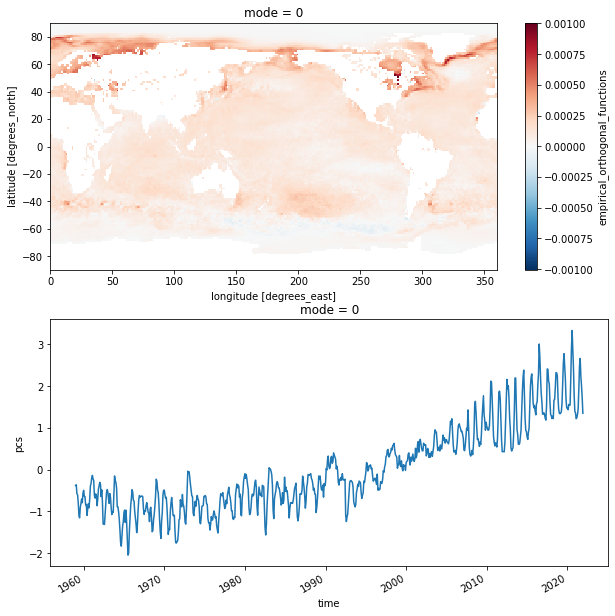

In [75]:
#let's see what EOF analysis tells us about the evolution of SST
plt.figure(figsize=(10,10))
ax=plt.subplot(2,1,1)
eofs.isel(mode=0).plot(ax=ax)
ax=plt.subplot(2,1,2)
pcs.isel(mode=0).plot(ax=ax)
#see how the zeroth EOF reflects the global warming trend: almost everywhere the sign of EOF is positive, and the time series show a long-term growth in time

/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


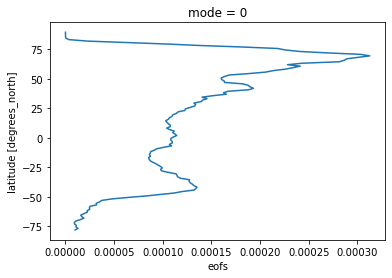

In [76]:
# Let's average the zeroth EOF over longitudes to see the latitudinal distribution of warming trends
# do you also see how the highlatitudes especially in the Northern Hemisphere are warming at a higher rate? 
# This is the so-called polar amplification!
eofs.isel(mode=0).mean(dim='longitude').plot(y='latitude'); 

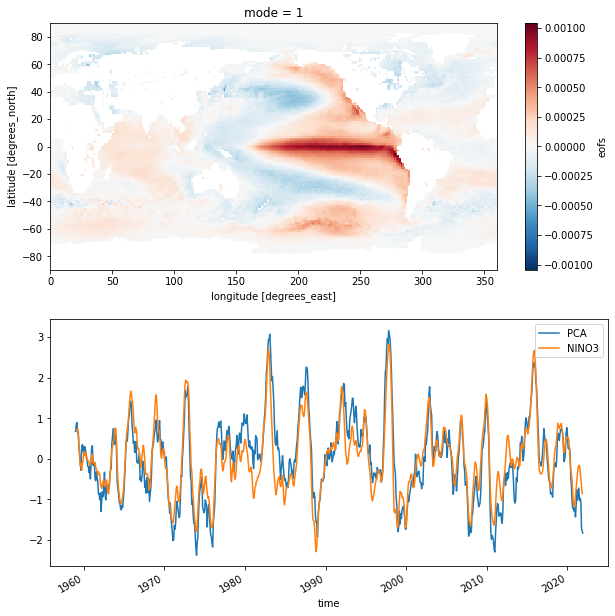

In [77]:
#the first EOF reflects prediminantly the ENSO signal: see how the spacial pattern is basically a footprint of El Nino and the time series are well correlated with the NINO3 Index.
plt.figure(figsize=(10,10))
ax=plt.subplot(2,1,1)
(-eofs).isel(mode=1).plot(ax=ax)
ax=plt.subplot(2,1,2)
(-pcs).isel(mode=1).plot(ax=ax)
NINO3.plot(ax=ax)
plt.legend(('PCA','NINO3'))

In [86]:
#Homework: figure out what happens in Seattle during ENSO events. Is it raining more or less? how about temperature? 
#Solution below:

Lat_Seattle=47.6062; Lon_Seattle=360-122.3321;  

prec_Seattle=era['tp'].sel(latitude=Lat_Seattle, longitude=Lon_Seattle,  method="nearest");

prec_Seattle_clim=prec_Seattle.groupby("time.month").mean('time'); # creating monthly mean climatology for sst
prec_Seattle_a = prec_Seattle.groupby("time.month")-prec_Seattle_clim;

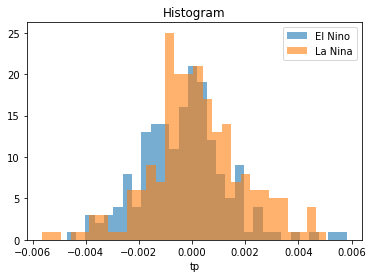

In [89]:
prec_Seattle_a[NINO3>0.5].plot.hist(bins=30,alpha=0.6)
prec_Seattle_a[NINO3<-0.5].plot.hist(bins=30,alpha=0.6)
plt.legend(('El Nino','La Nina'));
# looks like it precipitates a bit more during La Nina events, but not dramatically more.

(-4.0, 4.0)

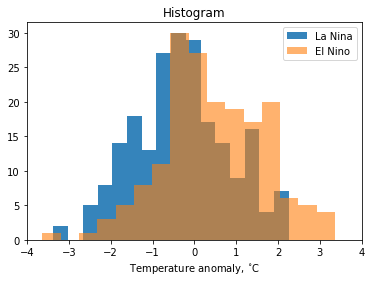

In [110]:
airtemp_Seattle=era['t2m'].sel(latitude=Lat_Seattle, longitude=Lon_Seattle,  method="nearest");

airtemp_Seattle_clim=airtemp_Seattle.groupby("time.month").mean('time'); # creating monthly mean climatology for sst
airtemp_Seattle_a = airtemp_Seattle.groupby("time.month")-airtemp_Seattle_clim;


airtemp_Seattle_a[NINO3<-0.5].plot.hist(bins=20,alpha=0.9)
airtemp_Seattle_a[NINO3>0.5].plot.hist(bins=20,alpha=0.6)
plt.legend(('La Nina','El Nino'));
plt.xlabel('Temperature anomaly, $^{\circ}$C');
plt.xlim((-4,4))
# How much hotter it is during strong El Nino and La Nina in Seattle?